In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2022-03-12 09:26:23.049811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/suman/.pyenv/versions/3.9.5/envs/machineLearningENV/lib/python3.9/site-packages/cv2/../../lib64:
2022-03-12 09:26:23.049840: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loading image data 

In [2]:
img_dir = '../data/'
no_tumor = os.listdir(img_dir + 'no/')
yes_tumor = os.listdir(img_dir + 'yes/')
dataset = []
label = []
input_size = 64
print(len(no_tumor), len(yes_tumor))

1500 1500


In [3]:
for i , image_name in enumerate(no_tumor):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(img_dir+'no/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((input_size,input_size))
        dataset.append(np.array(image))
        label.append(0)

for i , image_name in enumerate(yes_tumor):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(img_dir+'yes/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((input_size,input_size))
        dataset.append(np.array(image))
        label.append(1)
len(label)

3000

In [4]:
dataset=np.array(dataset)
label=np.array(label)


In [12]:
label_df = pd.Series(label)
label_df.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

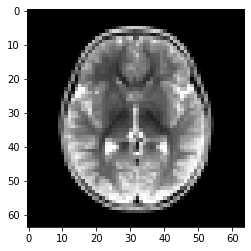

In [14]:
plt.imshow(dataset[1])

## EDA

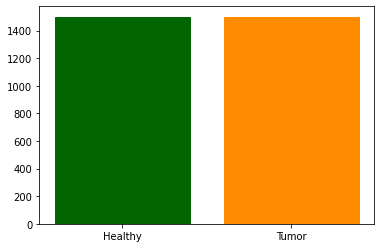

In [6]:
from collections import Counter 
# counts the number of occures of each label and save them in a dictionary
c = Counter(label)
#rename the keys and delete the old one
c["Healthy"] = c[0]
del c[0]
c['Tumor'] = c[1]
del c[1]
#plot each key and value in c 
plot=plt.bar(c.keys(), c.values())
plot[0].set_color('darkgreen')
plot[1].set_color('darkorange')

## Train Test Split

In [7]:
x_train, x_test, y_train, y_test=train_test_split(dataset, label, test_size=0.2, random_state=0)
x_train=normalize(x_train,axis=1)
x_test=normalize(x_test,axis=1)

## Model creation

In [8]:
model=models.Sequential()
# 1st conv2D layer
model.add(layers.Conv2D(32,(3,3),input_shape=(input_size,input_size,3)))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# # 2nd conv2D layer
model.add(layers.Conv2D(32,(3,3),kernel_initializer='he_uniform'))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# # 3rd conv2D layer
model.add(layers.Conv2D(32,(3,3),kernel_initializer='he_uniform'))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# # 4th conv2D layer
model.add(layers.Conv2D(32,(3,3),kernel_initializer='he_uniform'))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# # # # 5th conv2D layer
# model.add(layers.Conv2D(32,(3,3),kernel_initializer='he_uniform'))
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))

# # # 6th conv2D layer
# model.add(layers.Conv2D(32,(3,3),kernel_initializer='he_uniform'))
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(input_size))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 29, 29, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                    

2022-03-12 09:26:53.026538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/suman/.pyenv/versions/3.9.5/envs/machineLearningENV/lib/python3.9/site-packages/cv2/../../lib64:
2022-03-12 09:26:53.026578: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-12 09:26:53.026607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (machine): /proc/driver/nvidia/version does not exist
2022-03-12 09:26:53.026849: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

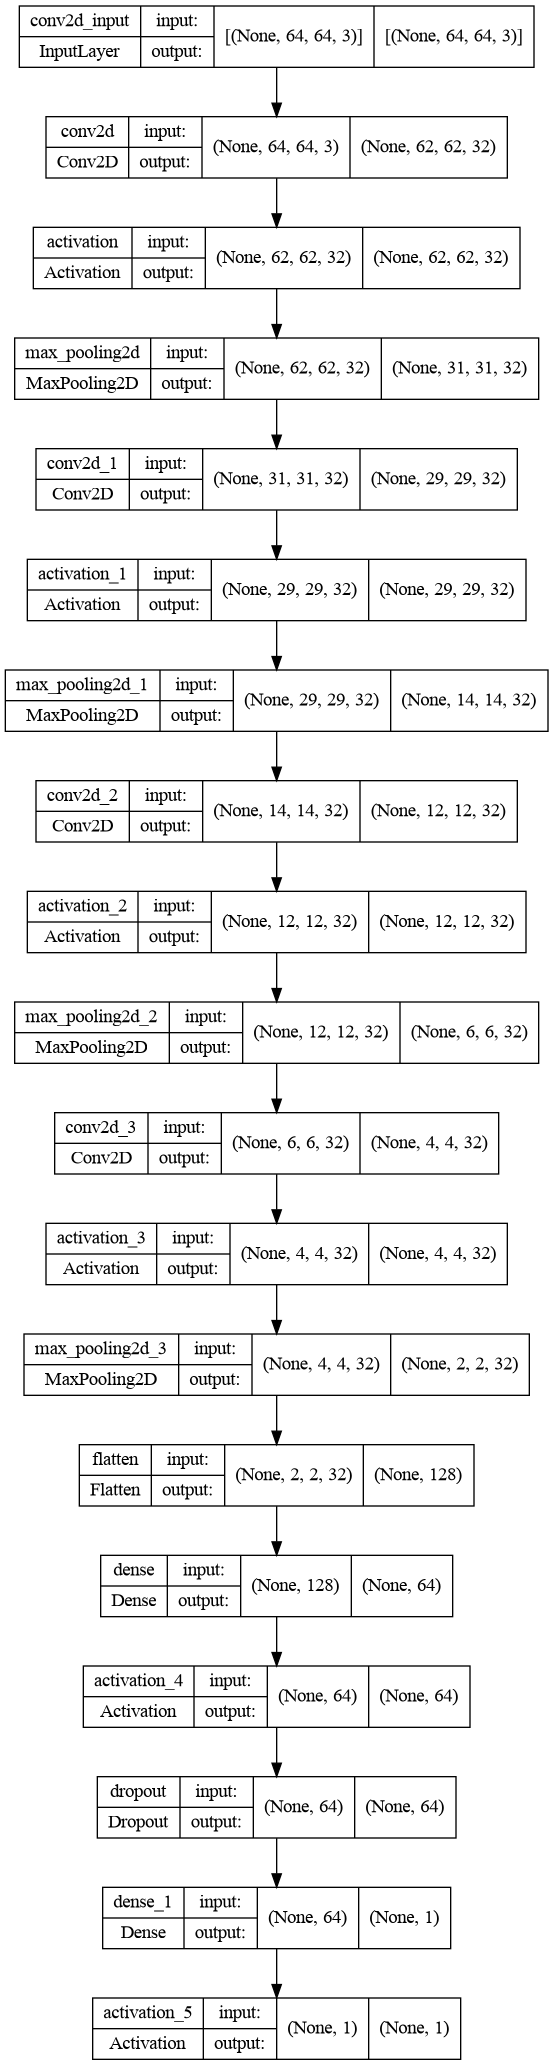

In [9]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          expand_nested=True)

In [10]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'orange', label='Training loss')
    axes[0].plot(Epochs,vloss,'blue',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'orange',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'blue',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

    plt.show()

In [11]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train,batch_size=16,verbose=1,epochs=17
          , validation_data=(x_test,y_test),
          shuffle=False)

Epoch 1/17
150/150 [==============================] - 5s 28ms/step - loss: 0.6009 - accuracy: 0.6646 - val_loss: 0.4473 - val_accuracy: 0.8217
Epoch 2/17
150/150 [==============================] - 4s 27ms/step - loss: 0.4201 - accuracy: 0.8100 - val_loss: 0.3345 - val_accuracy: 0.8450
Epoch 3/17
150/150 [==============================] - 3s 23ms/step - loss: 0.3108 - accuracy: 0.8721 - val_loss: 0.3219 - val_accuracy: 0.8783
Epoch 4/17
150/150 [==============================] - 3s 23ms/step - loss: 0.2486 - accuracy: 0.9029 - val_loss: 0.2512 - val_accuracy: 0.9067
Epoch 5/17
150/150 [==============================] - 4s 25ms/step - loss: 0.1857 - accuracy: 0.9317 - val_loss: 0.2038 - val_accuracy: 0.9233
Epoch 6/17
150/150 [==============================] - 4s 29ms/step - loss: 0.1244 - accuracy: 0.9567 - val_loss: 0.2271 - val_accuracy: 0.9150
Epoch 7/17
150/150 [==============================] - 4s 29ms/step - loss: 0.0959 - accuracy: 0.9671 - val_loss: 0.1553 - val_accuracy: 0.9433

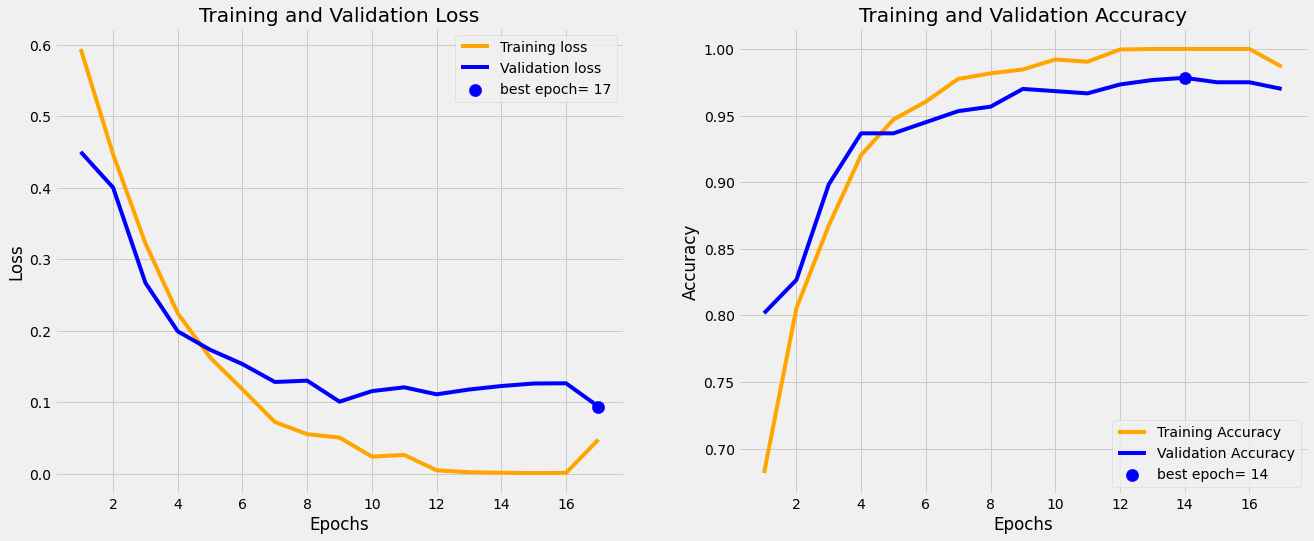

In [12]:
# plot the history
tr_plot(history,0)
model.save('BrainTumorDetection_model_3.h5')

In [13]:
loaded_model = tf.keras.models.load_model("BrainTumorDetection_model_3")

In [14]:
pred_data = []

image_test = cv2.imread("../data/archive/yes/Y1.jpg") 
image_test = Image.fromarray(image_test, 'RGB')
image_test = image_test.resize((input_size,input_size))
pred_data.append(np.array(image_test))
pred = np.asarray(pred_data)

In [15]:
model.predict(pred)

array([[1.]], dtype=float32)